<a href="https://colab.research.google.com/github/Seouyang/Today-I-Learned/blob/master/autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoder

In [1]:
#import required libraries
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
#set hyperparameters
batch_size = 256
learning_rate = 0.0002
num_epochs = 10

**MNIST dataset:** a dataset of 60,000 small square 28×28 pixel grayscale images of handwritten single digits between 0 and 9.

In [3]:
#download data
mnist_train = dset.MNIST("./", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test = dset.MNIST("./", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_train, mnist_val = torch.utils.data.random_split(mnist_train, [50000, 10000])

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
mnist_train[49999][0].size()

torch.Size([1, 28, 28])

In [5]:
mnist_train[49999][1]     #label

9

In [6]:
#set dataloader
dataloaders = {}
dataloaders['train'] = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
dataloaders['val'] = DataLoader(mnist_val, batch_size=batch_size, shuffle=False)
dataloaders['test'] = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

print(len(dataloaders['train'])) #50000/256
print(len(dataloaders['val']))
print(len(dataloaders['test']))

196
40
40


In [7]:
#model

class Autoencoder(nn.Module):
  def __init__(self):
    super(Autoencoder, self).__init__()
    self.encoder = nn.Sequential(
        nn.Linear(28*28, 100),
        nn.ReLU(),
        nn.Linear(100, 30),
        nn.ReLU()
    )
    self.decoder = nn.Sequential(
        nn.Linear(30, 100),
        nn.ReLU(),
        nn.Linear(100, 28*28),
        nn.Sigmoid()
    )

  def forward(self, x):
    batch_size = x.size(0)
    x = x.view(-1, 28*28)
    encoded = self.encoder(x)
    out = self.decoder(encoded).view(batch_size, 1, 28, 28)
    return out, encoded

In [8]:
#loss function & optimizer
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = Autoencoder().to(device)
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

cuda:0


In [12]:
#train
import time
import copy

def train_model(model, dataloaders, criterion, optimizer, num_epochs=10):
  since = time.time()
  train_loss_history = []
  val_loss_history = []
  
  best_model_wts = copy.deepcopy(model.state_dict())
  best_val_loss = 100000000

  for epoch in range(num_epochs): #1 epoch uses whole dataset
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    #each epoch has a training and validation phase
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()

      running_loss = 0.0
      
      for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        optimizer.zero_grad()
        with torch.set_grad_enabled(phase == 'train'):
          outputs, encoded = model(inputs)
          loss = criterion(outputs, inputs)

          if phase == 'train':
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * inputs.size(0)

      epoch_loss = running_loss / len(dataloaders[phase].dataset)
      print('{} Loss: {:.4f}'.format(phase, epoch_loss))

      if phase == 'train':
        train_loss_history.append(epoch_loss)
      if phase == 'val':
        val_loss_history.append(epoch_loss)
      if phase == 'val' and epoch_loss < best_val_loss:
        best_val_loss = epoch_loss
        best_model_wts = copy.deepcopy(model.state_dict())

    print()
  
  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
  print('Best val Loss: {:4f}'.format(best_val_loss))

  model.load_state_dict(best_model_wts)
  return model, train_loss_history, val_loss_history

In [13]:
best_model, train_loss_history, val_loss_history = train_model(model, dataloaders, loss_func, optimizer, num_epochs=num_epochs)

Epoch 0/9
----------
train Loss: 0.1159
val Loss: 0.0699

Epoch 1/9
----------
train Loss: 0.0661
val Loss: 0.0603

Epoch 2/9
----------
train Loss: 0.0555
val Loss: 0.0503

Epoch 3/9
----------
train Loss: 0.0460
val Loss: 0.0423

Epoch 4/9
----------
train Loss: 0.0397
val Loss: 0.0376

Epoch 5/9
----------
train Loss: 0.0360
val Loss: 0.0348

Epoch 6/9
----------
train Loss: 0.0335
val Loss: 0.0325

Epoch 7/9
----------
train Loss: 0.0311
val Loss: 0.0301

Epoch 8/9
----------
train Loss: 0.0290
val Loss: 0.0282

Epoch 9/9
----------
train Loss: 0.0273
val Loss: 0.0268

Training complete in 0m 44s
Best val Loss: 0.026767


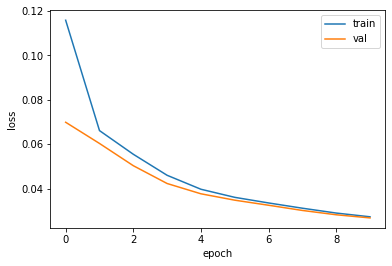

In [14]:
#learning curve
plt.plot(train_loss_history, label='train')
plt.plot(val_loss_history, label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [15]:
#test
with torch.no_grad():
  running_loss = 0.0
  for inputs, labels in dataloaders['test']:
    inputs = inputs.to(device)
    outputs, encoded = best_model(inputs)
    test_loss = loss_func(outputs, inputs)
    running_loss += test_loss.item() * inputs.size(0)
  test_loss = running_loss / len(dataloaders['test'].dataset)
  print(test_loss)

0.026162280970811844


torch.Size([16, 28, 28])


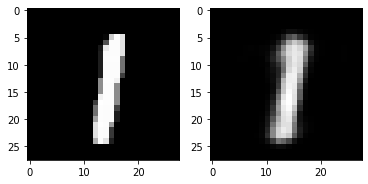

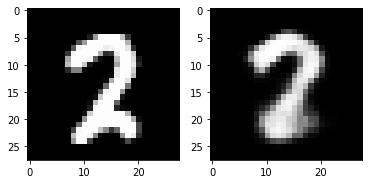

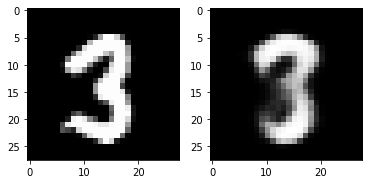

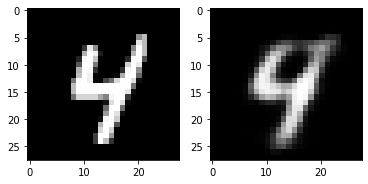

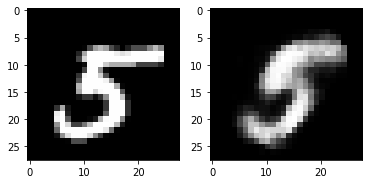

In [16]:
out_img = torch.squeeze(outputs.cpu().data)
print(out_img.size())

for i in range(5):
  plt.subplot(1, 2, 1)
  plt.imshow(torch.squeeze(inputs[i]).cpu().numpy(), cmap='gray')
  plt.subplot(1, 2, 2)
  plt.imshow(out_img[i].numpy(), cmap='gray')
  plt.show()

In [17]:
#visualization
np.random.seed(42)
from sklearn.manifold import TSNE

test_dataset_array = mnist_test.data.numpy() / 255
test_dataset_array = np.float32(test_dataset_array)
labels = mnist_test.targets.numpy()

In [18]:
test_dataset_array = torch.tensor(test_dataset_array)
inputs = test_dataset_array.to(device)
outputs, encoded = best_model(inputs)

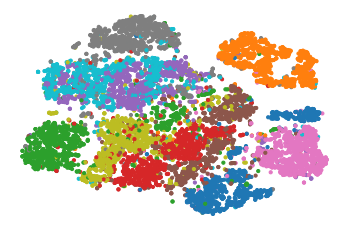

In [19]:
encoded = encoded.cpu().detach().numpy()
tsne = TSNE()
X_test_2D = tsne.fit_transform(encoded)
X_test_2D = (X_test_2D - X_test_2D.min()) / (X_test_2D.max() - X_test_2D.min())

plt.scatter(X_test_2D[:, 0], X_test_2D[:, 1], c=labels, s=10, cmap="tab10")
plt.axis("off")
plt.show()

# Denoising autoencoder

In [20]:
model_D = Autoencoder().to(device)
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model_D.parameters(), lr=learning_rate)

In [21]:
#adding noise to inputs
def train_model_D(model, dataloaders, criterion, optimizer, num_epochs=10):
  since = time.time()
  train_loss_history = []
  val_loss_history = []
  
  best_model_wts = copy.deepcopy(model.state_dict())
  best_val_loss = 100000000

  for epoch in range(num_epochs): #1 epoch uses whole dataset
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    #each epoch has a training and validation phase
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()

      running_loss = 0.0
      
      for inputs, labels in dataloaders[phase]:
        noise = torch.zeros(inputs.size(0), 1, 28, 28)
        nn.init.normal_(noise, 0, 0.1)
        noise = noise.to(device)
        inputs = inputs.to(device)
        noise_inputs = noise + inputs

        optimizer.zero_grad()
        with torch.set_grad_enabled(phase == 'train'):
          outputs, encoded = model(noise_inputs)
          loss = criterion(outputs, inputs)

          if phase == 'train':
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * inputs.size(0)

      epoch_loss = running_loss / len(dataloaders[phase].dataset)
      print('{} Loss: {:.4f}'.format(phase, epoch_loss))

      if phase == 'train':
        train_loss_history.append(epoch_loss)
      if phase == 'val':
        val_loss_history.append(epoch_loss)
      if phase == 'val' and epoch_loss < best_val_loss:
        best_val_loss = epoch_loss
        best_model_wts = copy.deepcopy(model.state_dict())

    print()
  
  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
  print('Best val Loss: {:4f}'.format(best_val_loss))

  model.load_state_dict(best_model_wts)
  return model, train_loss_history, val_loss_history

In [22]:
best_model_D, train_loss_history_D, val_loss_history_D = train_model_D(model_D, dataloaders, loss_func, optimizer, num_epochs=num_epochs)

Epoch 0/9
----------
train Loss: 0.1153
val Loss: 0.0694

Epoch 1/9
----------
train Loss: 0.0645
val Loss: 0.0605

Epoch 2/9
----------
train Loss: 0.0542
val Loss: 0.0477

Epoch 3/9
----------
train Loss: 0.0437
val Loss: 0.0406

Epoch 4/9
----------
train Loss: 0.0385
val Loss: 0.0367

Epoch 5/9
----------
train Loss: 0.0349
val Loss: 0.0334

Epoch 6/9
----------
train Loss: 0.0318
val Loss: 0.0305

Epoch 7/9
----------
train Loss: 0.0294
val Loss: 0.0287

Epoch 8/9
----------
train Loss: 0.0276
val Loss: 0.0268

Epoch 9/9
----------
train Loss: 0.0257
val Loss: 0.0250

Training complete in 0m 51s
Best val Loss: 0.025028


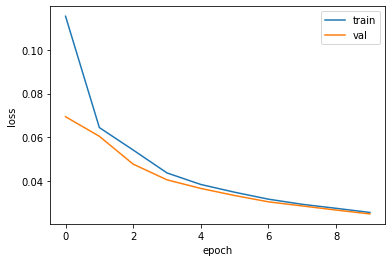

In [23]:
plt.plot(train_loss_history_D, label='train')
plt.plot(val_loss_history_D, label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [24]:
#test
with torch.no_grad():
  running_loss = 0.0
  for inputs, labels in dataloaders['test']:
    noise = nn.init.normal_(torch.FloatTensor(inputs.size(0), 1, 28, 28), 0, 0.1)
    noise = noise.to(device)
    inputs = inputs.to(device)
    noise_inputs = noise + inputs

    outputs, encoded = best_model_D(noise_inputs)
    test_loss = loss_func(outputs, inputs)
    running_loss += test_loss.item() * inputs.size(0)
  test_loss = running_loss / len(dataloaders['test'].dataset)
  print(test_loss)

0.024403921738266946


torch.Size([16, 28, 28])


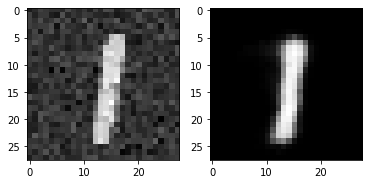

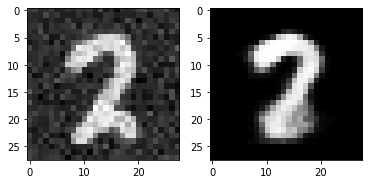

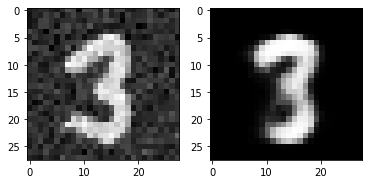

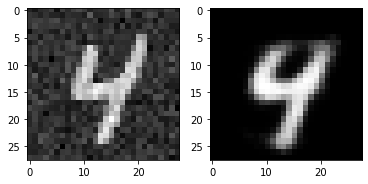

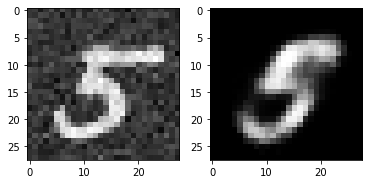

In [25]:
out_img = torch.squeeze(outputs.cpu().data)
print(out_img.size())

for i in range(5):
  plt.subplot(1, 2, 1)
  plt.imshow(torch.squeeze(noise_inputs[i]).cpu().numpy(), cmap='gray')
  plt.subplot(1, 2, 2)
  plt.imshow(out_img[i].numpy(), cmap='gray')
  plt.show()